# Milestone 2: Model Monitoring
### By Lakshmi Devesh Kumar

Business Context: 

Fashion Haven has successfully implemented a predictive model for sales revenue estimation based on their advertising campaigns across different media sources (TV, Newspaper, Radio). The model has been deployed in production, and it plays a crucial role in guiding the company's advertising budget allocation and overall marketing strategy. However, after the initial deployment, the company faces the challenge of monitoring the model's performance and ensuring its ongoing reliability and accuracy. Over time, the business environment may change, advertising trends could evolve, or external factors may impact customer behavior, all of which can influence the model's predictive capabilities. Fashion Haven needs to develop a robust model monitoring system to identify and address potential issues with the deployed sales revenue prediction model.

The goal of this model monitoring assignment is to implement a proactive approach to ensure the model's continued effectiveness and identify any degradation in its performance. By regularly monitoring the model, Fashion Haven can maintain the quality of predictions, make timely updates, and take corrective actions as needed.

The model monitoring system should provide the following key functionalities:

1. Data Drift Detection: The business environment is dynamic, and changes in customer behavior, market trends, or competitor strategies may cause data distribution to drift over time. The monitoring system should identify and measure data drift in the input features used by the model, helping the team understand how well the model adapts to new data.

2. Model Drift Checks: Regular calibration checks will ensure that the model's predicted probabilities align with the observed outcomes. If the model becomes miscalibrated, corrective actions should be taken to recalibrate it for accurate probability estimates.

## Creating endpoints (0 Mark)


This part of the project will check your skills related to model monitoring. We are providing the below codes to train and deploy the model. You can use these codes to do long-term monitoring checks. Watch the previous LVC recording and refer to the Week 8: Model Monitoring LVC notebook and MLS 8: Model Monitoring: AWS MLS notebook.

**General Imports**

In [2]:
import json
import ast

import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, chi2_contingency, ttest_rel

In [3]:
sns.set_context("talk")

**SageMaker Imports**

In [4]:
import boto3
import sagemaker

from sagemaker.sklearn.estimator import SKLearn, SKLearnModel
from sagemaker.model_monitor import DataCaptureConfig

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


**Authentication**

In [5]:
session = sagemaker.Session()

In [6]:
try:
    aws_role = sagemaker.get_execution_role()
except ValueError:
    print('Local configuration is not complete; use SageMaker Studio')

In [7]:
print(f"AWS execution role associated with the account {aws_role}")
print(f"Default bucket associated with the account: {session.default_bucket()}")
print(f"Default boto region associated with the account: {session.boto_region_name}")

AWS execution role associated with the account arn:aws:iam::583418938145:role/service-role/AmazonSageMaker-ExecutionRole-20240611T124233
Default bucket associated with the account: sagemaker-us-east-1-583418938145
Default boto region associated with the account: us-east-1


**Setup**

In [8]:
monitoring_session = sagemaker.session.Session(
    default_bucket="sagemaker-us-east-1-583418938145"
)

In [9]:
monitoring_session.default_bucket()

'sagemaker-us-east-1-583418938145'

**Model Training**

We use the `SKLearn` estimator to estimate a model from the training data.

In [10]:
%%writefile gbr.py

import os
import joblib
import pandas as pd

# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import make_column_transformer

from sklearn.ensemble import GradientBoostingRegressor

# from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split


def main():
    
    training_data_directory = "/opt/ml/input/data/train"
    model_output_directory = "/opt/ml/model"
    
    input_data_path = os.path.join(
        training_data_directory, 
        "processed_data.csv"
    )
    
    data = pd.read_csv(input_data_path)

    target = 'Sales'


    X = data.drop(columns=['Sales'])
    y = data[target]

    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


    model_gbr = GradientBoostingRegressor(
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100
    )

    print("Training Gradient Boosting Regressor")

    model_gbr.fit(Xtrain, ytrain)

    print("Predicting on test data")

    ypred = model_gbr.predict(Xtest)

    print(f"RMSE: {mean_squared_error(ytest, ypred, squared=False)};")
    print(f"R-squared: {model_gbr.score(Xtest, ytest)};")

    model_output_path = os.path.join(model_output_directory, "model.joblib")

    print(f"Saving model to {model_output_path}")
    joblib.dump(model_gbr, model_output_path)
    

if __name__ == "__main__":
    main()

Overwriting gbr.py


In [11]:
sklearn_gbr_estimator = SKLearn(
    entry_point="gbr.py",
    framework_version="1.2-1",
    role=aws_role,
    sagemaker_session=monitoring_session,
    instance_type="ml.m4.xlarge",
    instance_count=1,
    volume_size=1
)

In [12]:
!aws s3 cp processed_data.csv s3://sagemaker-us-east-1-583418938145/milestone2/

upload: ./processed_data.csv to s3://sagemaker-us-east-1-583418938145/milestone2/processed_data.csv


In [13]:
!aws s3 cp proc_syn.csv s3://sagemaker-us-east-1-583418938145/milestone2/

upload: ./proc_syn.csv to s3://sagemaker-us-east-1-583418938145/milestone2/proc_syn.csv


In [14]:
!aws s3 cp advertising_ground_truth.csv s3://sagemaker-us-east-1-583418938145/milestone2/

upload: ./advertising_ground_truth.csv to s3://sagemaker-us-east-1-583418938145/milestone2/advertising_ground_truth.csv


In [87]:
!aws s3 ls s3://sagemaker-us-east-1-583418938145/milestone2/

2024-07-21 18:02:24        113 advertising_ground_truth.csv
2024-07-21 18:02:23        834 proc_syn.csv
2024-07-21 18:02:22      12733 processed_data.csv


In [15]:
sklearn_gbr_estimator.fit(
    inputs={
    'train': 's3://sagemaker-us-east-1-583418938145/milestone2/'
    },
    wait=False,
    job_name='2024-07-21-estimate-gbr-04-5'
)

INFO:sagemaker:Creating training-job with name: 2024-07-21-estimate-gbr-04-5


*The model artifacts are stored in the `output` folder within the location created by the training job*

In [16]:
artifacts_gbr = "s3://sagemaker-us-east-1-583418938145/2024-07-21-estimate-gbr-04-5/output/model.tar.gz"

**Model Deployment**

In [17]:
%%writefile inference.py

import os
import joblib

import pandas as pd

from io import StringIO


def model_fn(model_dir):
    '''
    This function is called when the server is instantiated for the first time.
    SageMaker injects the model directory (/opt/ml/model) when the function is 
    called. We reference and load the model pipeline binary from this 
    directory
    '''
    print(f"loading model.joblib from: {model_dir}")
    model_pipeline = joblib.load(os.path.join(model_dir, "model.joblib"))
    return model_pipeline


def input_fn(request_body, request_content_type):
    '''
    This function is called each time a prediction request is received. 
    We check for the type of the input and restrict the inputs to csv files
    If we receive a csv input, we convert the input to a pandas DataFrame
    object. This DataFrame serves as an input to the model for prediction
    '''
    if request_content_type == "text/csv":
        data_df = pd.read_csv(StringIO(request_body))
        return data_df
    else:
        print("Received unknown input")
        pass


def predict_fn(input_data, model):
    '''
    This function is called each time a prediction request is received.
    SageMaker injects the processed input data from the input_fn and the model
    loaded from the model_fn as parameters 
    '''
    return model.predict(input_data)

Overwriting inference.py


In [18]:
model_gbr = SKLearnModel(
    model_data=artifacts_gbr,
    role=aws_role,
    sagemaker_session=monitoring_session,
    entry_point="inference.py",
    framework_version="1.2-1"
)

In [19]:
model_monitor_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=30,
    destination_s3_uri="s3://sagemaker-us-east-1-583418938145/2024-07-21-monitor-gbr-model",
    capture_options=["REQUEST", "RESPONSE"],
)

In [20]:
predictor_gbr = model_gbr.deploy(
    endpoint_name='gbr-06',
    instance_type="ml.m4.xlarge",
    initial_instance_count=1,
    data_capture_config=model_monitor_config,
    wait=False
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-07-23-18-17-36-619
INFO:sagemaker:Creating endpoint-config with name gbr-06
INFO:sagemaker:Creating endpoint with name gbr-06


## Test data for monitoring 

Read the advertising_synthetic.csv file 

In [21]:
test_df = pd.read_csv("proc_syn.csv")

Print the length and info of the dataframe 

In [22]:
print("length: ",len(test_df))

length:  19


In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         19 non-null     float64
 1   Radio      19 non-null     float64
 2   Newspaper  19 non-null     float64
 3   Sales      19 non-null     float64
dtypes: float64(4)
memory usage: 736.0 bytes


Define the numeric features and the target variable 

In [24]:
numeric_features = ['TV', 'Radio', 'Newspaper']
target = 'Sales'

Define the variable called features and assign the numeric features columns 

In [25]:
features = numeric_features

In [26]:
features

['TV', 'Radio', 'Newspaper']

Define the sample_Xtest and sample_ytest 

In [27]:
sample_Xtest = test_df[features]
sample_ytest = test_df['Sales']

In [28]:
sample_Xtest.head()

,TV,Radio,Newspaper
0,0.969852,0.981522,1.778945
1,-1.197376,1.082808,0.669579
2,-1.516155,1.528463,1.783549
3,0.052050,1.217855,1.286405
4,0.394182,-0.841614,1.281802


Define a SageMaker runtime and invoke the endpoint and check the status code 

In [29]:
#Define SageMaker runtime
sagemaker_runtime = boto3.client("sagemaker-runtime")

In [30]:
#Invoke the endpoint
response = sagemaker_runtime.invoke_endpoint(
    EndpointName = predictor_gbr.endpoint_name,
    Body = sample_Xtest.to_csv(header=True, index=False).encode("utf-8"),
    ContentType = "text/csv"
)

In [31]:
#Print the response from endpoint
response

{'ResponseMetadata': {'RequestId': '657c4193-b476-4914-90af-5d8f60601d24',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '657c4193-b476-4914-90af-5d8f60601d24',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Tue, 23 Jul 2024 18:24:47 GMT',
   'content-type': 'application/json',
   'content-length': '371',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f266c2acdc0>}

In [32]:
#Check status code of response 
response['ResponseMetadata']['HTTPStatusCode']

200

## Implementing long-term monitoring 

Read the advertising dataset

In [33]:
training_data = pd.read_csv('processed_data.csv')

### Accessing Logs 

In [34]:
# Invoke endpoint 10 times to generate enough logs
for _ in range(10):
    response = sagemaker_runtime.invoke_endpoint(
        EndpointName = predictor_gbr.endpoint_name,
        Body = sample_Xtest.sample(10).to_csv(header=True, index=False).encode("utf-8"),
        ContentType = "text/csv"
    )

In [35]:
aws_log_file = '2024-07-21-monitor-gbr-model/gbr-06/AllTraffic/2024/07/23/18/25-16-593-2217a646-41be-4e4d-b2fe-c829909d1611.jsonl'

In [36]:
aws_log_file

'2024-07-21-monitor-gbr-model/gbr-06/AllTraffic/2024/07/23/18/25-16-593-2217a646-41be-4e4d-b2fe-c829909d1611.jsonl'

**AWS log files are stored as `json` lists. So we need a custom function that loads these log files from the S3 bucket**

In [37]:
# read jsonl from s3 bucket
def read_json1_from_s3(bucket, key):
    s3 = boto3.client('s3')
    data_object = s3.get_object(
        Bucket = bucket,
        Key = key
    )
    text = data_object['Body'].read().decode('utf-8')
    return text.split('\n')

In [38]:
aws_predictions = read_json1_from_s3(
    bucket = "sagemaker-us-east-1-583418938145",
    key = aws_log_file
)

In [39]:
#Print the log output
aws_predictions

['{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"TV,Radio,Newspaper\\n0.969852266,0.981522472,1.778945467\\n-0.313436589,-0.247406325,-0.872486994\\n-0.925304978,0.9004942,3.841170715\\n-1.615408448,1.731033991,2.045929986\\n-1.439087595,0.799208859,1.627040482\\n-0.94515567,-1.179231457,-0.292486143\\n0.394182198,-0.841613655,1.281801881\\n-1.197376228,1.082807813,0.66957876\\n-1.516154988,1.52846331,1.783548649\\n-1.616576136,-1.42906863,-1.360424218\\n","encoding":"CSV"},"endpointOutput":{"observedContentType":"application/json","mode":"OUTPUT","data":"[22.051134455061725, 13.041357716067397, 13.41130087003041, 7.236531202694393, 9.234837056057598, 8.676001420411271, 12.972214573164386, 10.463774187392104, 9.267577087957873, 4.747782679391745]","encoding":"JSON"}},"eventMetadata":{"eventId":"d4e026de-e95a-4dd0-8512-1d25032c6b61","inferenceTime":"2024-07-23T18:25:16Z"},"eventVersion":"0"}',
 '{"captureData":{"endpointInput":{"observedContentT

**Let us extract the observed predictions into a list**

In [40]:
model_predictions_aws_list = []

In [41]:
for prediction in aws_predictions:
    if prediction != '':
        prediction_data = json.loads(prediction)
        model_predictions_aws_list.extend(
            json.loads(
                prediction_data['captureData']['endpointOutput']['data']
            )
        )

In [42]:
len(model_predictions_aws_list)

20

### Target Checks 

Create a boxplot to check the distribution of price in the training data and the distribution of predicted price from the deployed model. 

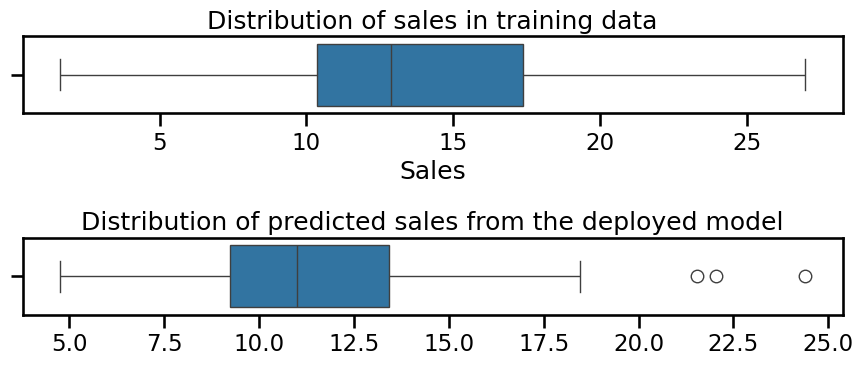

In [43]:
plt.figure(figsize=(9, 4))
plt.subplot(211)
sns.boxplot(x='Sales', data=training_data)
plt.title("Distribution of sales in training data")
plt.subplot(212)
sns.boxplot(x=model_predictions_aws_list)
plt.title("Distribution of predicted sales from the deployed model")
plt.tight_layout()
plt.show()

**Kolmogorov-Smirnov test** 

In [44]:
#Calculate the p-value using the K-S test
statistic, p_value = ks_2samp(
            training_data[target].values,
            model_predictions_aws_list
)

In [45]:
#Print p-value
p_value

0.16305626365149908

Observation 

*Since the p-value is >0.05 , there is no significant difference between the model predictions and the target distribution in the training data.*

### Data Drift 

In [46]:
threshold = 0.05
features_with_data_drift = []

Create a loop to check features with data drift

In [47]:
for k, feature in enumerate(sample_Xtest.columns):
    
    statistic, p_value = ks_2samp(
        training_data[feature].values,
        sample_Xtest[feature].values
    )
    
    if p_value < threshold:
        features_with_data_drift.append(feature)

In [48]:
features_with_data_drift

['Newspaper']

Observation:

. The drift in ['Newspaper'] is potentially the reason why there is a drift in the predicted targets (e.g., outlier predictions).

### Model Drift 

Read the advertising_ground_truth.csv file

In [49]:
ground_truth_sales = pd.read_csv('advertising_ground_truth.csv')

In [50]:
# Length of ground truth
len(ground_truth_sales)

19

In [51]:
ground_truth_sales.head()

,Sales
0,22.1
1,10.4
2,9.3
3,18.5
4,12.9


We now present the same synthetic data (on which ground truth is now available) to the endpoint.

In [52]:
response = sagemaker_runtime.invoke_endpoint(
    EndpointName = predictor_gbr.endpoint_name,
    Body = sample_Xtest.to_csv(header=True, index=False).encode("utf-8"),
    ContentType = "text/csv"
)

In [53]:
model_predictions_aws = ast.literal_eval(
    response["Body"].read().decode("utf-8")
)

In [54]:
len(model_predictions_aws)

19

Check the two sample ttest

In [55]:
two_sample_ttest = ttest_rel(model_predictions_aws, ground_truth_sales['Sales'])

In [56]:
#Print the p-value of the two sample test
two_sample_ttest.pvalue

0.7879019852812252

Observations:

. Since the p value is greater than 0.05, we conclude that there is no significant difference between the model predictions and the ground truth.

## Delete the Endpoint

In [57]:
predictor_gbr.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: gbr-06
INFO:sagemaker:Deleting endpoint with name: gbr-06
